In [1]:
import eee

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

### Specify ensemble

This ensemble has three species:

hdna + 2IPTG <--> h + 2IPTG <--> l2e

+ `hdna` (our observable, with dG0 = 0 kcal/mol)
+ `h` (unobserved structure that does not bind to anything; dG0 = 5 kcal/mol)
+ `l2e` (unobserved structure that binds to 2 iptg molecules; dG0 = 5 kcal/mol)

At highly positive IPTG concentration (low concentration), `hdna` will be highly favored. At highly negative IPTG concentrations (high concentration), `l2e` is favored. 


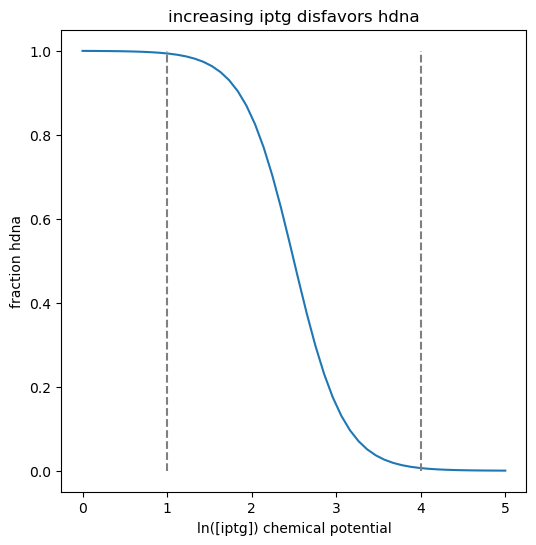

In [2]:
ens = eee.Ensemble()
ens.add_species("hdna",dG0=0,observable=True)
ens.add_species("h",dG0=5)
ens.add_species("l2e",dG0=5,mu_stoich={"iptg":2},observable=False)

df = ens.get_obs(mu_dict={"iptg":np.linspace(0,5)})
fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(df.iptg,df.fx_obs)
ax.set_xlabel("ln([iptg]) chemical potential")
ax.set_ylabel("fraction hdna")

ax.plot((1,1),(0,1),'--',color='gray')
ax.plot((4,4),(0,1),'--',color='gray')
ax.set_title("increasing iptg disfavors hdna")
None

### Load in $\Delta \Delta G$

Load in a spreadsheet with the energetics effects of mutations on all species in the ensemble. 

In [3]:
ddg_df = eee.io.load_ddg("../tests/data_for_tests/test_ddg/ddg.csv")
ddg_df

,site,mut,hdna,h,l2e
0,1,L1A,6.778,7.941,4.4385
1,1,L1C,8.147,11.205,7.6000
2,1,L1D,-0.234,1.073,3.2910
3,1,L1E,7.648,8.496,4.2360
4,1,L1F,1.447,4.023,-0.4560
...,...,...,...,...,...
75,4,G4S,15.472,35.673,20.0280
76,4,G4T,15.428,43.397,36.3300
77,4,G4V,24.131,39.590,45.7680
78,4,G4W,79.753,96.205,46.9070


### Simulate evolution

For this, we are going to use the `eee.evolve.simulate_evolution` function. First, see what it's arguments are.


### Run evolutionary simulation

In this run, we select over 100 generations for the protein to be `on` for both $\mu _{iptg} = -4$ and $\mu _{iptg} = -1$. Our population size is 1000 and our mutation rate 0.01.

In [7]:
sc = eee.simulation.calcs.WrightFisherSimulation(ens=ens,
                                                 ddg_df=ddg_df,
                                                 mu_dict={"iptg":[1,4]},
                                                 fitness_fcns=["off","on"],
                                                 select_on="fx_obs",
                                                 select_on_folded=True)
# Delete output directory if it already exists
import os
import shutil
if os.path.exists("test_run"):
    shutil.rmtree("test_run")

sc.run(output_directory="test_run",
       population_size=1000,
       mutation_rate=0.01,
       num_generations=1000)

  0%|          | 0/999 [00:00<?, ?it/s]

In [8]:
import json
import os
print(os.listdir("test_run/"))

with open("test_run/simulation.json") as f:
    run_info = json.load(f)
print(run_info)

['eee_sim_generations_0.pickle', 'ddg.csv', 'eee_sim_genotypes.csv', 'simulation.json']
{'calc_type': 'wf_sim', 'system': {'ens': {'hdna': {'dG0': 0.0, 'observable': True, 'mu_stoich': {}, 'folded': True}, 'h': {'dG0': 5.0, 'observable': False, 'mu_stoich': {}, 'folded': True}, 'l2e': {'dG0': 5.0, 'observable': False, 'mu_stoich': {'iptg': 2.0}, 'folded': True}, 'R': 0.001987}, 'mu_dict': {'iptg': [1.0, 4.0]}, 'select_on': 'fx_obs', 'select_on_folded': True, 'fitness_kwargs': {}, 'T': [298.15, 298.15], 'fitness_fcns': ['off', 'on'], 'seed': 865709948979, 'ddg_df': 'ddg.csv'}, 'calc_params': {'population_size': 1000, 'mutation_rate': 0.01, 'num_generations': 1000, 'write_prefix': 'eee_sim', 'write_frequency': 1000}}


In [9]:
import pandas as pd

genotypes = pd.read_csv("test_run/eee_sim_genotypes.csv")
genotypes

,genotype,mutations,num_mutations,accum_mut,num_accum_mut,parent,trajectory,hdna_ddg,h_ddg,l2e_ddg,fitness
0,0,NaN,0,NaN,0,NaN,[0],0.0000,0.000,0.000,4.078957e-05
1,1,L2E,1,L2E,1,0.0,"[0, 1]",20.3320,13.826,16.097,4.739041e-06
2,2,I3C,1,I3C,1,0.0,"[0, 2]",14.5010,12.625,18.840,4.601261e-03
3,3,L2Q,1,L2Q,1,0.0,"[0, 3]",14.7750,5.833,10.664,6.087638e-06
4,4,L2G,1,L2G,1,0.0,"[0, 4]",15.9270,-0.565,12.784,3.761729e-09
...,...,...,...,...,...,...,...,...,...,...,...
9971,9971,I3C/L2D/L1D/G4W,4,I3C/L2D/L1D/G4K/K4W,5,522.0,"[0, 2, 75, 281, 522, 9971]",110.6560,122.707,84.790,6.900810e-22
9972,9972,I3C/L1D/G4K/L2S,4,I3C/L2D/L1D/G4K/D2S,5,522.0,"[0, 2, 75, 281, 522, 9972]",83.8885,88.751,94.183,5.906280e-08
9973,9973,L2D/L1D/G4K/I3Y,4,I3C/L2D/L1D/G4K/C3Y,5,522.0,"[0, 2, 75, 281, 522, 9973]",83.9320,78.358,83.908,4.307873e-03
9974,9974,L2D/L1D/G4K/I3E,4,I3C/L2D/L1D/G4K/C3E,5,522.0,"[0, 2, 75, 281, 522, 9974]",92.7560,89.661,99.708,3.704907e-02


In [10]:
import pickle
with open("test_run/eee_sim_generations_0.pickle","rb") as f:
    generations = pickle.load(f)

# First three generation
generations[:3]

[{0: 1000},
 {0: 990, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1},
 {0: 877,
  2: 102,
  10: 8,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1}]

### Extract gentoype frequencies from the simulation

  0%|          | 0/1000 [00:00<?, ?it/s]

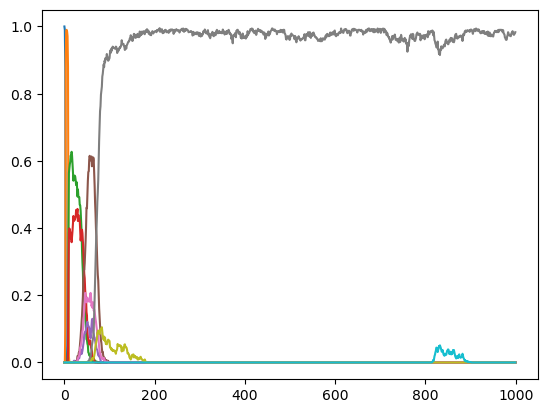

In [11]:
df = eee.simulation.analysis.get_genotype_frequencies(generations)
gen = np.arange(len(generations))
for x in df.columns:
    plt.plot(gen,df[x],'-')  
    